<a href="https://colab.research.google.com/github/WidyaIn/MACHINE_LEARNING-SEM-5/blob/main/modul10_Praktikum%2Btugas_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAMA : WIDYA INDAH PUSPITA SARI

# KELAS : TI-3A

# NIM : 2141720034

# **PRAKTIKUM 1**

# **Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

# **Setup input pipeline**

Download dataset menggunakan TFDS.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'The great and underrated Marion Davies shows her stuff in this late (1928) silent comedy that also showcases the wonderful William Haines. Davies plays a hick from Georgia who crashes Hollywood with help from Haines. They appear in cheap comedies until Marion is "discovered" and becomes a big dramatic star. A great lampoon on Hollywood and its pretentions. Davies & Haines are a wonderful team (too bad they never made a talkie together) and the guest shots from the likes of Charlie Chaplin, Douglas Fairbanks, William S. Hart, John Gilbert, Elinor Glynn, and Marion Davies (you have to see it) are a hoot. A must for any serious film buff or for anyone interested in the still-maligned Marion Davies!'
 b"If, in the first 10 minutes of this film, you don't realize that the main character, who writes a life advice column, is going to have the tables-oh-so-cleverly-turned and learn some valuable life lessons himself, then there is probably something wrong with you. The set up is so 


Ini diformat sebagai kode


# **Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 2, 85,  3, ...,  0,  0,  0],
       [45,  8,  2, ...,  0,  0,  0],
       [56,  1, 21, ...,  0,  0,  0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The great and underrated Marion Davies shows her stuff in this late (1928) silent comedy that also showcases the wonderful William Haines. Davies plays a hick from Georgia who crashes Hollywood with help from Haines. They appear in cheap comedies until Marion is "discovered" and becomes a big dramatic star. A great lampoon on Hollywood and its pretentions. Davies & Haines are a wonderful team (too bad they never made a talkie together) and the guest shots from the likes of Charlie Chaplin, Douglas Fairbanks, William S. Hart, John Gilbert, Elinor Glynn, and Marion Davies (you have to see it) are a hoot. A must for any serious film buff or for anyone interested in the still-maligned Marion Davies!'
Round-trip:  the great and [UNK] [UNK] [UNK] shows her stuff in this late [UNK] [UNK] comedy that also [UNK] the wonderful [UNK] [UNK] [UNK] plays a [UNK] from [UNK] who [UNK] hollywood with help from [UNK] they appear in cheap [UNK] until [UNK] is [UNK] and becomes a big dramatic

# **Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00511938]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.00511938]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 105ms/step - loss: 0.6359 - accuracy: 0.5701 - val_loss: 0.5341 - val_accuracy: 0.7240
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4587 - accuracy: 0.7708 - val_loss: 0.4184 - val_accuracy: 0.8083
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3858 - accuracy: 0.8262 - val_loss: 0.3802 - val_accuracy: 0.8323
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3503 - accuracy: 0.8478 - val_loss: 0.3503 - val_accuracy: 0.8469
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3315 - accuracy: 0.8616 - val_loss: 0.3382 - val_accuracy: 0.8479
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3182 - accuracy: 0.8663 - val_loss: 0.3365 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3114 - accuracy: 0.8679 - val_loss: 0.3274 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3186 - accuracy: 0.8626
Test Loss: 0.31864815950393677
Test Accuracy: 0.8626000285148621


(0.0, 0.6526413694024086)

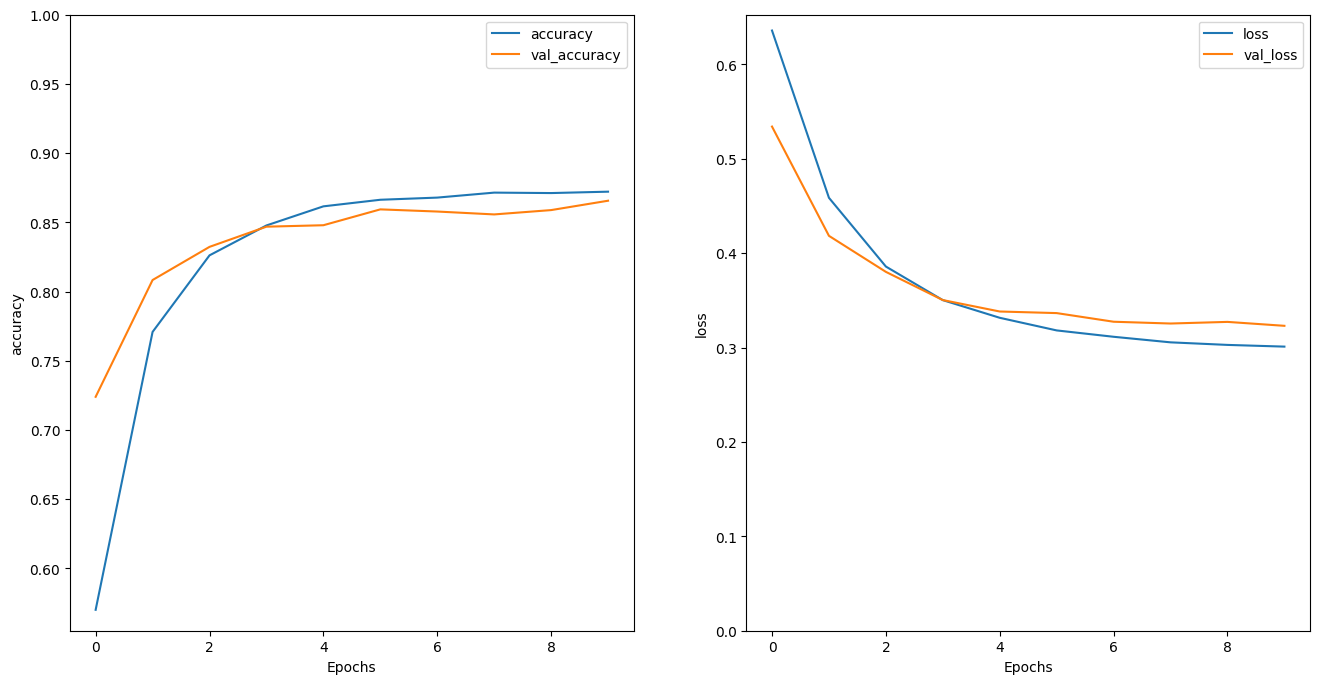

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


# **Stack two or more LSTM layers**

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 149ms/step - loss: 0.6241 - accuracy: 0.5906 - val_loss: 0.4383 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3845 - accuracy: 0.8316 - val_loss: 0.3461 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3348 - accuracy: 0.8593 - val_loss: 0.3382 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3200 - accuracy: 0.8649 - val_loss: 0.3237 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3114 - accuracy: 0.8689 - val_loss: 0.3292 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3064 - accuracy: 0.8700 - val_loss: 0.3219 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3005 - accuracy: 0.8715 - val_loss: 0.3311 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 67ms/step - loss: 0.3156 - accuracy: 0.8619
Test Loss: 0.31562182307243347
Test Accuracy: 0.8619199991226196


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.32285]]


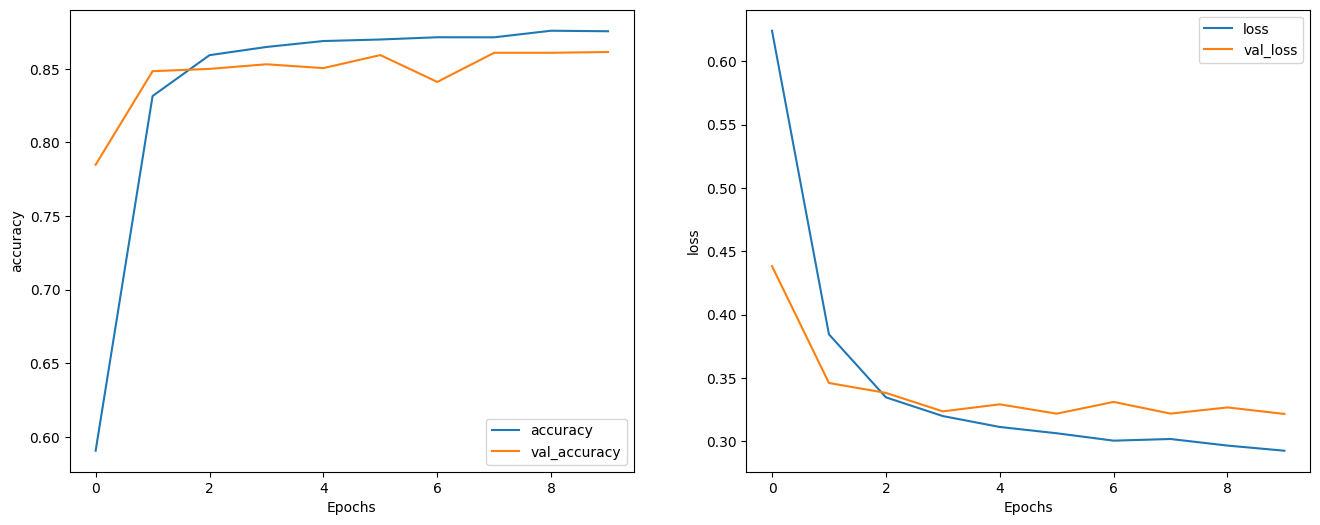

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **PRAKTIKUM 2**


# **Setup**

## Import TensorFlow

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [26]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


## Load Data

In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# **Olah Teks**

## Vectorize Teks

In [30]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
# sekarang buat tf.keras.layers.StringLookup layer:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [32]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## Prediksi, Membuat Trianing Set dan Target

In [37]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [40]:
seq_length = 100

In [41]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [42]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Membuat Batch Training

In [47]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# **Buat Model**

tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;

In [48]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# **Uji Model**

## Cek bentuk dari output

In [51]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


## Masukan dengan panjang berapa pun

In [52]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Mengambil sampel dari distribusi keluaran

In [53]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

## Prediksi indeks karakter berikutnya

In [54]:
sampled_indices

array([16, 11, 20, 36,  3, 51, 39, 10, 29, 27, 64, 25, 38, 18,  4, 36, 22,
       34, 55, 27, 62, 37, 18, 52, 49, 27, 27, 13, 24, 56, 55, 57,  5,  7,
       10, 13, 43, 36, 53, 23,  1, 12, 36, 31, 55, 27, 30,  5, 30, 32, 38,
       54, 64, 30, 12, 14, 52, 65, 44,  0, 31, 37, 10,  4, 61, 30, 23,  3,
       42, 37, 38, 36, 44, 31,  2, 64,  6, 34, 33, 64, 41,  1, 38, 21, 24,
       11, 52,  3, 21, 49,  6, 41, 31, 56, 24, 18, 62, 65,  4,  7])

## Melihat teks yang diprediksi oleh model tidak terlatih ini

In [55]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' I for comfort have but one false glass,\nWhich grieves me when I see my shame in him.\nThou art a wid'

Next Char Predictions:
 b"C:GW!lZ3PNyLYE$WIUpNwXEmjNN?Kqpr&,3?dWnJ\n;WRpNQ&QSYoyQ;Amze[UNK]RX3$vQJ!cXYWeR y'UTyb\nYHK:m!Hj'bRqKEwz$,"


# **Train Model**

## Tambahan optimizer dan fungsi loss

In [56]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.191305, shape=(), dtype=float32)


In [58]:
tf.exp(example_batch_mean_loss).numpy()

66.10902

In [59]:
model.compile(optimizer='adam', loss=loss)

## Konfigurasi Checkpoints

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Lakukan Proses Training

In [61]:
EPOCHS = 20

In [62]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 57ms/step - loss: 2.7414
Epoch 2/20
172/172 [==============================] - 13s 57ms/step - loss: 1.9952
Epoch 3/20
172/172 [==============================] - 13s 59ms/step - loss: 1.7157
Epoch 4/20
172/172 [==============================] - 11s 56ms/step - loss: 1.5511
Epoch 5/20
172/172 [==============================] - 11s 57ms/step - loss: 1.4520
Epoch 6/20
172/172 [==============================] - 11s 56ms/step - loss: 1.3839
Epoch 7/20
172/172 [==============================] - 11s 57ms/step - loss: 1.3318
Epoch 8/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2867
Epoch 9/20
172/172 [==============================] - 13s 58ms/step - loss: 1.2458
Epoch 10/20
172/172 [==============================] - 13s 58ms/step - loss: 1.2057
Epoch 11/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1660
Epoch 12/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1244
E

# **Generate Teks**

In [63]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [64]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [65]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
And must be ready.

Roman:
Was not my design? no, though ne'er good
upon thieves; hence with wings of Luncaster leads
Imends and folks and patry in the county.

DUCHESS OF YORK:
What, will my bond after thee?

GRUMIO:
She was, I know thy county was a man,
Though rehem ever be not to be passing me:
Nay, loving friends, that cannot live
That which you are mere jocund.

LUCIO:
I never saw you so reciven and return'd his holing
boning dismal here in Bohemia, they but reading me
Thy lightness unto a rouble of chasts
to make it fled to thee and craves. Thou know'st
That it was married to our country bears,
And sacing stretch thy lips and death both begun.
Upon thy father Camillo Walwing hit him meane?

QUEEN ELIZABETH:
By this island we will come; therefore prepare him!

Tubour back.

SLY:
I'll keep my bliss. Will this be previneable for us!

GLOUCESTER:
My lord, I could not be spoke of; for 'her's humoured,
No bigger and heil of his judgment Duke of hell.
This name to call the power 

In [66]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nO, sir, I am struck with thee?\n\nLARTIUS:\nThis is the point of quarrel of the king;\nThen let befain use parden fe:\nDid but weather's place home. Play her! I have\nholded sent: tell me he will say than tongue\nWill over that our birth'd lives, the other talk'd\nAs if he died at kingdom, not this young prince,\nand title lain wrought it not, nor noble three,\nI'll prove them; but he must die for him;\nIt will be loop'd on Richard's son, as well\nwe were upon the childs or levour.\n\nSecond Citizen:\nI mean these self.\n\nDUKE OF YORK:\nHere, he is an hour since: he might painted in.\n\nJULIET:\nAway, away. Tail nothing but most wisdom in the war,\nHow to be seit but my love's i'state,\nNot whited heavenly heir to-morrow.\nI would my sight she will be Werriod Show you from being knowledge.\n\nGLOUCESTER:\nAt thy nurse! for Edward Part! But yet, thou know'st\nThy true hither away towards Lancaster to our Irranct, I will look on.\n\nSecond Citizen:\nAy, and this my

# **Ekspor Model Generator**

In [67]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [68]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Then fair queen, that he hath done me wrong.

KING RICHARD II:
Good like, young bannstly that we cr


# **TUGAS**

## **Prosedurnya adalah:**


1. Jalankan Model dan hitung loss dengan tf.GradientTape.

2. Hitung update dan terapkan pada model dengan optimizer

In [69]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
          grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

> Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.



In [70]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [71]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [72]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 56ms/step - loss: 2.7088




> Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:



In [73]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

# saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1933
Epoch 1 Batch 50 Loss 2.0528
Epoch 1 Batch 100 Loss 1.9446
Epoch 1 Batch 150 Loss 1.8072

Epoch 1 Loss: 1.9825
Time taken for 1 epoch 13.17 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7748
Epoch 2 Batch 50 Loss 1.7698
Epoch 2 Batch 100 Loss 1.6529
Epoch 2 Batch 150 Loss 1.6298

Epoch 2 Loss: 1.7016
Time taken for 1 epoch 11.28 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6000
Epoch 3 Batch 50 Loss 1.5645
Epoch 3 Batch 100 Loss 1.5381
Epoch 3 Batch 150 Loss 1.4876

Epoch 3 Loss: 1.5417
Time taken for 1 epoch 11.46 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4815
Epoch 4 Batch 50 Loss 1.4433
Epoch 4 Batch 100 Loss 1.4169
Epoch 4 Batch 150 Loss 1.4055

Epoch 4 Loss: 1.4465
Time taken for 1 epoch 11.20 sec
_____________________________________________________________________

3. Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

perbandingan antara Praktikum 2 dan Pelatihan Tugas adalah sebagai berikut:

1.Arsitektur Model:

Praktikum 2 menggunakan model bahasa yang berdasarkan RNN (Recurrent Neural Network), sementara pada Pelatihan Tugas mungkin digunakan arsitektur yang berbeda, seperti GRU (Gated Recurrent Unit) dalam modelnya.
Praktikum 2 tampaknya lebih simpel dalam hal desain model karena berfungsi sebagai demonstrasi dasar. Model pada Pelatihan Tugas memiliki komponen yang lebih kompleks, termasuk lapisan embedding, lapisan GRU, dan lapisan dense.

2.Jumlah Epoch:

Dalam Praktikum 2, model dijalankan selama 20 epoch, sementara pada Pelatihan Tugas, model dilatih selama 10 epoch.

3.Prosedur Pelatihan:

Praktikum 2 lebih simpel dalam metode pelatihannya dan menggunakan API model.fit() bawaan dari Keras.
Pada Pelatihan Tugas, terdapat implementasi loop pelatihan yang lebih khusus dengan menggunakan train_step, memberikan lebih banyak kontrol atas proses pelatihan, termasuk pengukuran loss, perhitungan gradien, dan optimisasi.

4.Output Hasil Pelatihan:

Hasil dari Praktikum 2 memberikan informasi ringkas tentang loss selama pelatihan tanpa rincian tambahan mengenai perubahan loss antar epoch atau waktu eksekusi.
Dalam Pelatihan Tugas, terdapat pencatatan loss untuk setiap batch dan setiap epoch, serta waktu yang dibutuhkan untuk menjalankan setiap epoch.

5.Waktu Eksekusi:

Waktu eksekusi per epoch dapat bervariasi antara kedua eksperimen karena Praktikum 2 mungkin lebih cepat dalam pengaturan defaultnya, sedangkan pada Pelatihan Tugas, waktu eksekusi mungkin lebih lama karena menjalankan model selama lebih banyak epoch.